In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     data	experiments  Index.ipynb  models  project-structure.md	requirements.txt
config.yaml  datautils	Index_bc.py  index.py	  output  README.md		run.yaml


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder


In [5]:
# setup some imports
#custom imports
from common.transforms import ToTensor
from datautils.datareader import DataReader
from datautils.dataset import CustomDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.conv_net import ConvNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from common.visualization import Visualization
from experiments.test_model import ModelTester

In [6]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [7]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 128, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'l1', 'epoch_interval': 10, 'num_epochs': 100}, 'model': {'name': 'conv_net', 'optimizer': 'Adam', 'lr': 8e-05, 'weight_decay': 1e-07, 'amsgrad': True, 'momentum': 0.9}, 'test_model': False}


In [8]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [9]:
#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

#preprocess data or load preprocessed data
dr = DataReader()
ds = dr.get_split_data()
Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)

#transform data
composed_transforms =  transforms.Compose([
    ToTensor()
])
#convert to dataset
ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
te_dataset = CustomDataset(Lte, ABte, te_len)
smlen = int(0.01 * len(ftr_dataset))
smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
smftrte_dataset = torch.utils.data.Subset(ftr_dataset, list(range(10)))
smtelen = int(0.1 * len(te_dataset))
smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
print('Full train dataset length:', len(ftr_dataset))
print('Test dataset length:', len(te_dataset))
print('Subset train dataset length:', smlen)
print('Subset test dataset length:', smtelen, '\n')


Shape of X and y: (50000, 1, 32, 32) (50000, 2, 32, 32)
Full train dataset length: 50000
Test dataset length: 10
Subset train dataset length: 500
Subset test dataset length: 1 



In [10]:
#model training with small dataset
exp = Experiment(exp_params["model"]["name"], smftr_dataset)
model_history = exp.train()

Running straight split
	Running Epoch 1


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


	Epoch 1 Training Loss: 0.1504142937064171
	Epoch 1 Validation Loss: 0.11373738944530487
	Running Epoch 10


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 25.20it/s]


	Epoch 10 Training Loss: 0.09927789449691772
	Epoch 10 Validation Loss: 0.09841424971818924
	Running Epoch 20


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


	Epoch 20 Training Loss: 0.0930611664056778
	Epoch 20 Validation Loss: 0.0924709290266037
	Running Epoch 30


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


	Epoch 30 Training Loss: 0.08871126830577851
	Epoch 30 Validation Loss: 0.09010881185531616
	Running Epoch 40


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s]


	Epoch 40 Training Loss: 0.0862900298833847
	Epoch 40 Validation Loss: 0.08634182065725327
	Running Epoch 50


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s]


	Epoch 50 Training Loss: 0.08248565137386323
	Epoch 50 Validation Loss: 0.08738522231578827
	Running Epoch 60


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]


	Epoch 60 Training Loss: 0.07945619702339173
	Epoch 60 Validation Loss: 0.08366261422634125
	Running Epoch 70


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s]


	Epoch 70 Training Loss: 0.07397638499736786
	Epoch 70 Validation Loss: 0.0905560851097107
	Running Epoch 80


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s]


	Epoch 80 Training Loss: 0.0673837423324585
	Epoch 80 Validation Loss: 0.08690749108791351
	Running Epoch 90


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


	Epoch 90 Training Loss: 0.06294542670249939
	Epoch 90 Validation Loss: 0.09347686916589737
	Running Epoch 100


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 23.95it/s]


	Epoch 100 Training Loss: 0.05938376173377037
	Epoch 100 Validation Loss: 0.09225939214229584



Model validation results

Model results




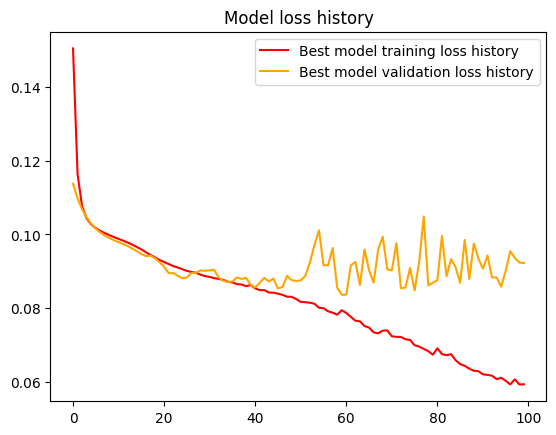


Model Training Loss: 0.05938376173377037
Model Validation Loss: 0.09225939214229584


In [11]:
# get best model with small dataset
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')
print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()

In [12]:
#model training with full dataset
'''
exp = Experiment(exp_params["model"]["name"], ftr_dataset)
model_history = exp.train()
'''

'\nexp = Experiment(exp_params["model"]["name"], ftr_dataset)\nmodel_history = exp.train()\n'

In [13]:
# get best model
'''
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')

print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()
'''

'\nmodel, model_history, _ = get_model_data(exp_params["model"]["name"])\n#model = get_saved_model(model, \'\')\nmodel_info = get_modelinfo(\'\')\n\nprint("\nModel validation results")\n#visualization results\nvis = Visualization(model_info, model_history)\nvis.get_results()\n'



Testing Saved Model


<Figure size 640x480 with 0 Axes>

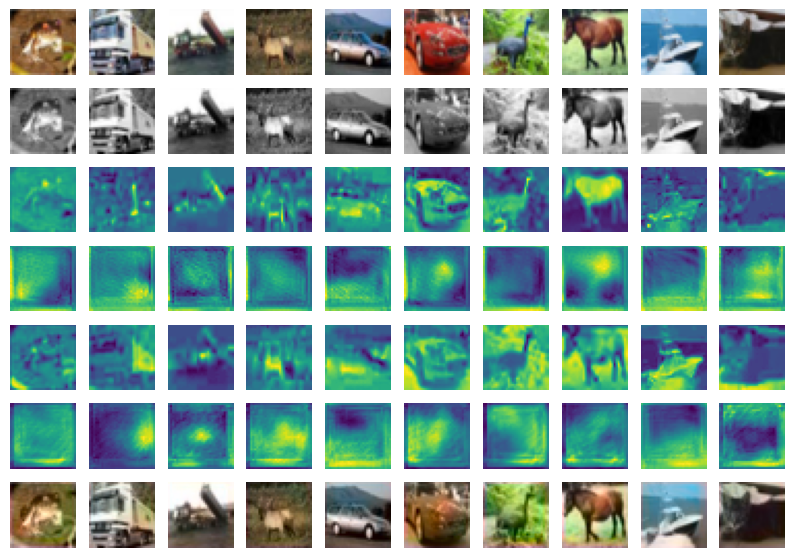


Test Loss: 0.08232923597097397
Test Accuracy: tensor(0.) 



In [14]:
#model testing with small subset of training dataset
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smftrte_dataset)
mt.test_and_plot(ds["RGBtr"], ABtr, "best_model", True)



Testing Saved Model


<Figure size 640x480 with 0 Axes>

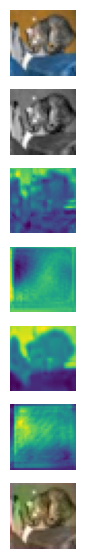


Test Loss: 0.14772263169288635
Test Accuracy: tensor(0.) 



In [15]:
#model testing with small test data
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smfte_dataset)
mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)



Testing Saved Model


<Figure size 640x480 with 0 Axes>

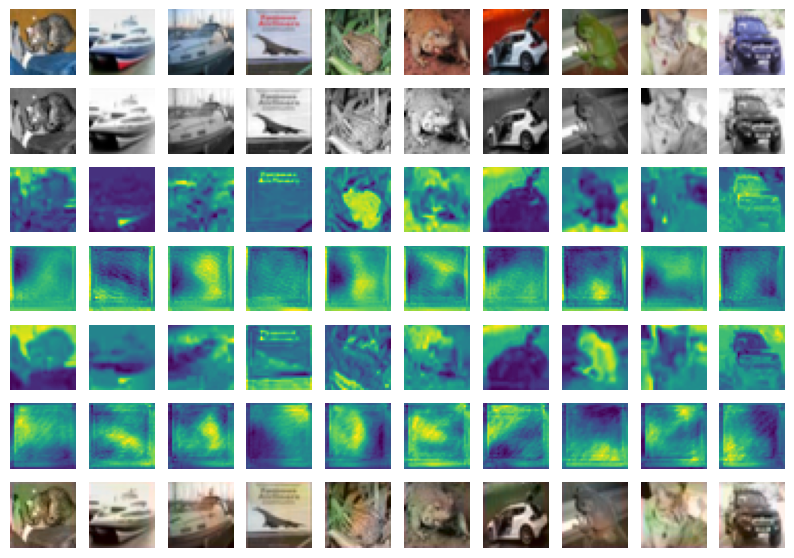


Test Loss: 0.11502861976623535
Test Accuracy: tensor(0.) 



In [16]:
#model testing with whole test data
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, te_dataset)
mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)